#  CSTR fault detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.io
import matplotlib.image as mpimg

/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


(-0.5, 1096.5, 551.5, -0.5)

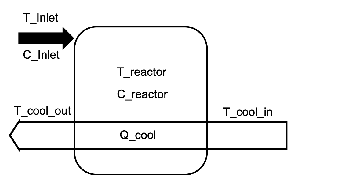

In [2]:
cstr= mpimg.imread('cstr.png')
plt.imshow(cstr)
plt.axis('off')

In [3]:
mat = scipy.io.loadmat('cstr_fault_time_series.mat')


In [4]:
fault_label=mat["fault_labels"].flatten()
data = pd.DataFrame({'C_inlet':mat["data"][:, 0], 'T_inlet':mat["data"][:, 1] \
                     ,'C_reactor':mat["data"][:, 2], 'T_reactor':mat["data"][:, 3] \
                     ,'Q_cool':mat["data"][:, 4], 'T_cool_in':mat["data"][:, 5]\
                     ,'T_cool_out':mat["data"][:, 6],'fault':fault_label
                    
                    })
data.head()

,C_inlet,C_reactor,Q_cool,T_cool_in,T_cool_out,T_inlet,T_reactor,fault
0,1.027647,0.099224,148.841248,348.638761,416.686204,350.360361,430.879667,0
1,1.027779,0.094646,157.013774,348.713451,417.987404,350.299300,432.911189,0
2,1.026808,0.108838,154.560242,349.188551,414.600037,349.971868,429.661746,0
3,1.026215,0.097684,157.220063,348.729069,416.656083,350.640629,432.256645,0
4,1.026132,0.100689,162.379105,348.849656,416.179071,350.595431,431.304828,0


In [5]:
normal=data[data['fault']==0]
normal = normal.drop('fault', 1)

In [6]:
corr = normal.corr()
corr.style.background_gradient(cmap=cm.plasma)

,C_inlet,C_reactor,Q_cool,T_cool_in,T_cool_out,T_inlet,T_reactor
C_inlet,1,0.337727,0.865872,-0.103169,-0.430025,-0.14273,0.0325988
C_reactor,0.337727,1,0.160318,-0.0381804,-0.958128,-0.0298583,-0.904093
Q_cool,0.865872,0.160318,1,0.143554,-0.30809,0.0522386,0.19717
T_cool_in,-0.103169,-0.0381804,0.143554,1,0.0407638,0.0529842,-0.00447289
T_cool_out,-0.430025,-0.958128,-0.30809,0.0407638,1,-0.0336354,0.85825
T_inlet,-0.14273,-0.0298583,0.0522386,0.0529842,-0.0336354,1,-0.0174267
T_reactor,0.0325988,-0.904093,0.19717,-0.00447289,0.85825,-0.0174267,1


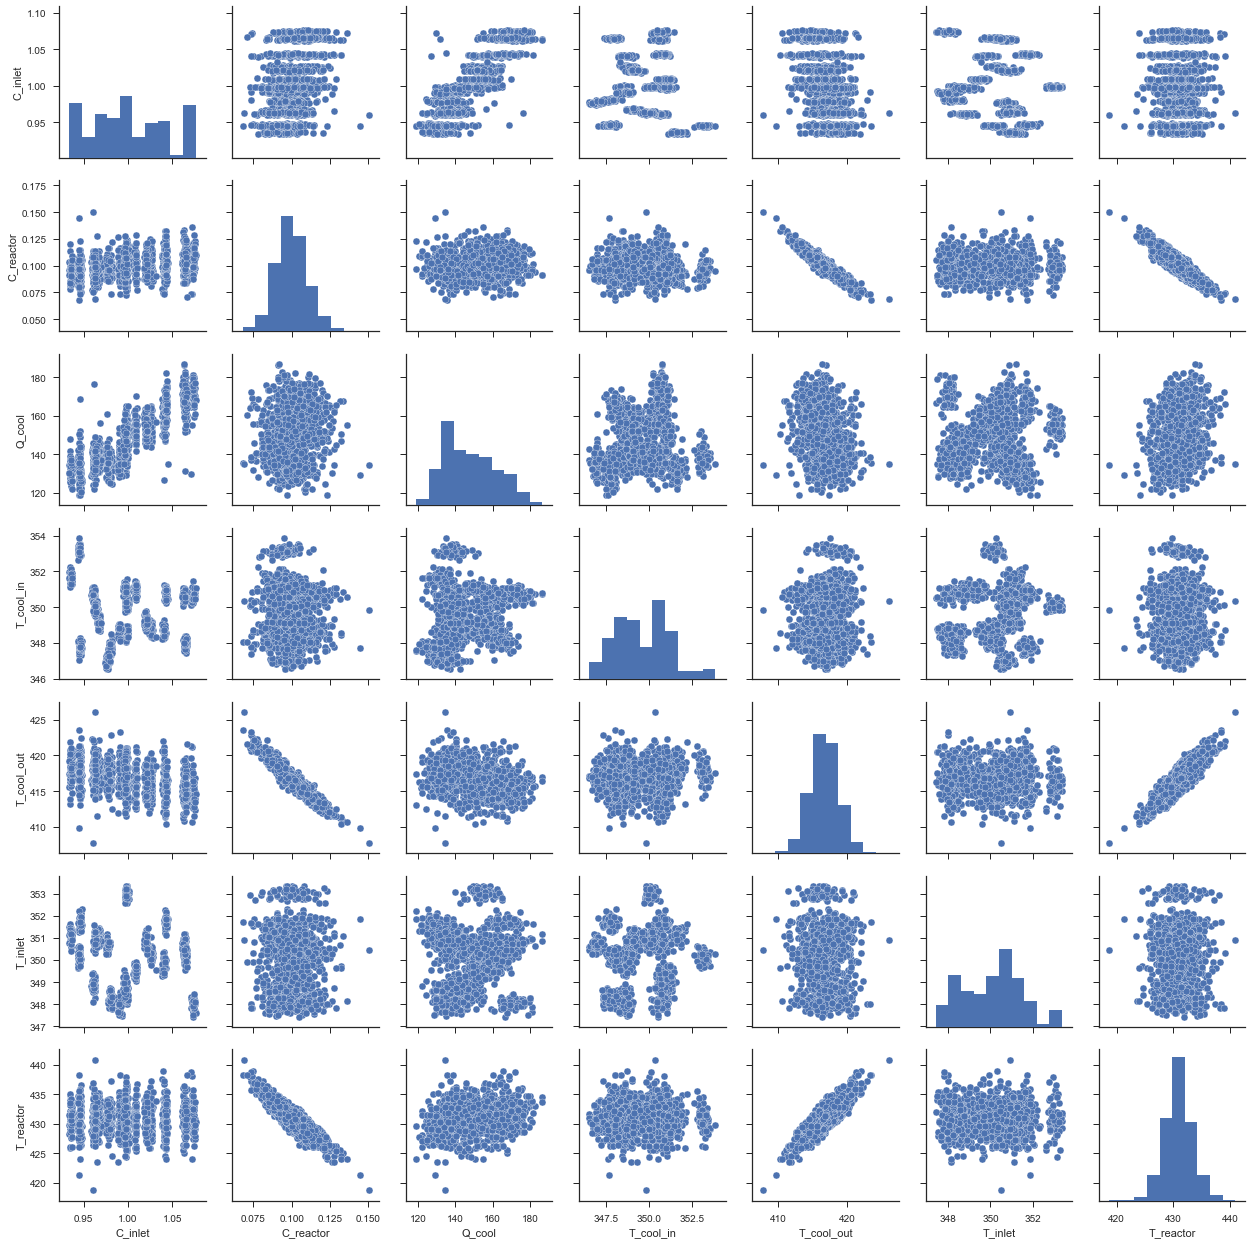

In [8]:
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(normal)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121f31ac8>,
      dtype=object)

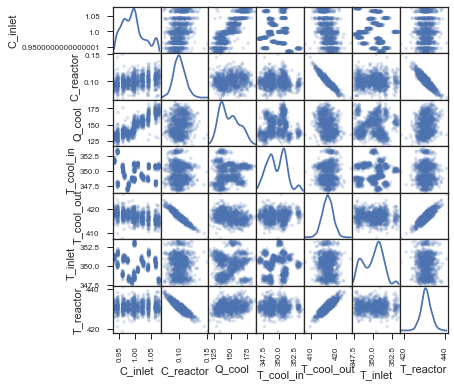

In [9]:

from pandas.plotting import scatter_matrix
scatter_matrix(normal, alpha=0.2, figsize=(6, 6), diagonal='kde')

/anaconda/lib/python3.6/site-packages/seaborn/distributions.py:400: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


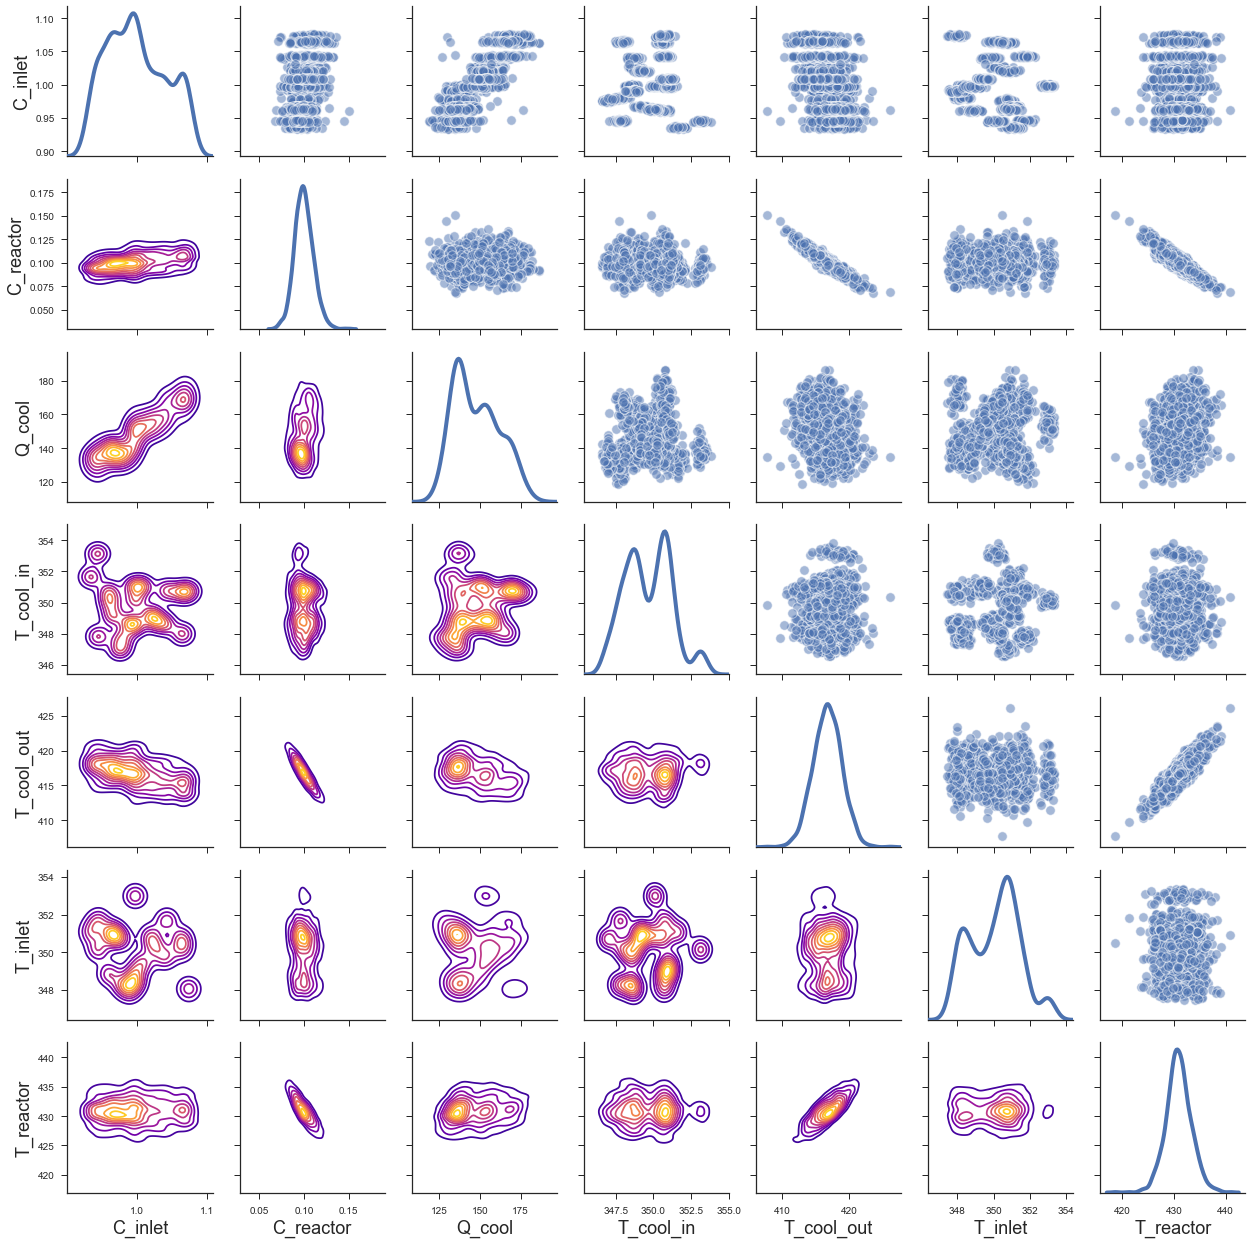

In [13]:
import matplotlib
matplotlib.pyplot.rcParams["axes.labelsize"] = 18
g = sns.PairGrid(normal, diag_sharey=False)
axes = g.axes
g.map_upper(matplotlib.pyplot.scatter,  linewidths=1, 
            edgecolor="w", s=90, alpha = 0.5)
g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap=cm.plasma)
matplotlib.pyplot.show()

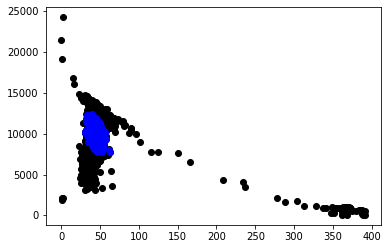

In [73]:

plt.scatter(data['T_reactor']*data['C_reactor'],data['Q_cool']*(data['T_cool_out'] -data['T_cool_in']),c="k")
plt.scatter(normal['T_reactor']*normal['C_reactor'],normal['Q_cool']*(normal['T_cool_out'] -normal['T_cool_in']),c="b")